In [37]:
%matplotlib inline
from fastai.basics import *

In [20]:
! wget  http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-03-17 11:19:47--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  8.12MB/s    in 1.9s    

2019-03-17 11:19:49 (8.12 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [21]:
! ls mnist.pkl.gz

mnist.pkl.gz


In [2]:
path = Config().data_path()/'mnist'

In [26]:
! mkdir -p {path}

In [28]:
! mv mnist.pkl.gz {path}

In [3]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz')]

In [4]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

In [5]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

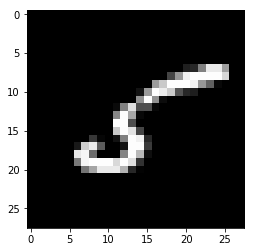

In [6]:
plt.imshow(x_train[11].reshape(28, 28), cmap="gray")

In [7]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, [x_train, y_train, x_valid, y_valid])

In [8]:
n, c = x_train.shape

In [9]:
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [10]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [11]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [12]:
class Mnist_logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        
    def forward(self, xb): 
        return self.lin(xb)

In [13]:
model = Mnist_logistic().cuda()

In [14]:
model

Mnist_logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [15]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [16]:
np.allclose(model.lin(x), model(x)), model(x).shape

(True, torch.Size([64, 10]))

In [17]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [18]:
lr = 2e-2

In [19]:
loss_func = nn.CrossEntropyLoss()

In [20]:
def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)
    loss = loss_func(y_hat, y) + wd * sum((p**2).sum() for p in model.parameters())
    loss.backward()
    with torch.no_grad():
        for p in model.parameters(): 
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [21]:
loss_func(model(x), y)

tensor(2.3508, device='cuda:0', grad_fn=<NllLossBackward>)

In [22]:
losses = [update(x, y, lr) for x, y in data.train_dl]

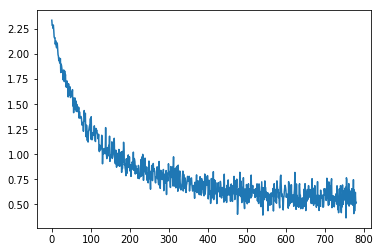

In [23]:
plt.plot(losses);

In [24]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [25]:
model = Mnist_NN().cuda()

In [26]:
losses = [update(x, y, lr) for x, y in data.train_dl]

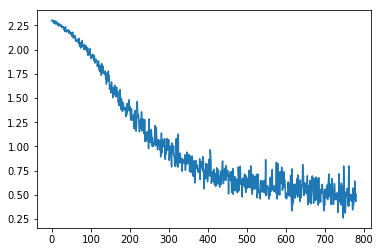

In [27]:
plt.plot(losses);

In [28]:
model = Mnist_NN().cuda()

In [29]:
def update(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [30]:
losses = [update(x, y, 1e-3) for x, y in data.train_dl]

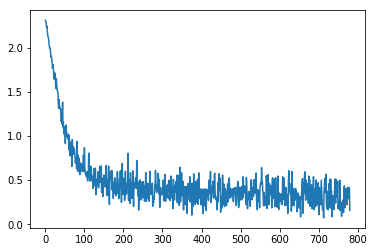

In [31]:
plt.plot(losses);

In [34]:
Learner?

In [35]:
loss_func

CrossEntropyLoss()

In [39]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

AttributeError: 'TensorDataset' object has no attribute 'loss_func'

In [40]:
%debug

> /opt/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py(20)DataLoader___getattr__()
     18 torch.utils.data.DataLoader.__init__ = intercept_args
     19 
---> 20 def DataLoader___getattr__(dl, k:str)->Any: return getattr(dl.dataset, k)
     21 DataLoader.__getattr__ = DataLoader___getattr__
     22 

ipdb> u
> /opt/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py(38)__getattr__()
     36 
     37     def __len__(self)->int: return len(self.dl)
---> 38     def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
     39     def __setstate__(self,data:Any): self.__dict__.update(data)
     40 

ipdb> print(k)
loss_func
ipdb> q


In [41]:
learn.lr_find()

NameError: name 'learn' is not defined